In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    try:
        os.chdir(os.path.abspath(os.path.join(os.path.abspath(os.path.dirname(__vsc_ipynb_file__)), os.pardir)))
        print("Working on local machine...")
    except:
        print("Can't change directory. Quitting...")
        exit(1)

Working on local machine...


In [2]:
from deep_learning import predict

In [3]:
import pandas as pd
import numpy as np
import pytz
from qstrader import settings
from qstrader.alpha_model.fixed_signals import FixedSignalsAlphaModel
from qstrader.asset.equity import Equity
from qstrader.asset.universe.static import StaticUniverse
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.data.daily_bar_csv import CSVDailyBarDataSource
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading.backtest import BacktestTradingSession
from qstrader.broker.fee_model.percent_fee_model import PercentFeeModel


In [4]:

def load_data(csv_file):
    """
    Load the S&P 500 data from a CSV file.
    """
    return pd.read_csv(csv_file, index_col='Date', parse_dates=True)

In [5]:
class PredictiveAlphaModel(FixedSignalsAlphaModel):
    def __init__(self, data, lookback_period, model):
        self.model = model
        print(f"Using pretrained model: {model}")
        self.data = data
        self.lookback_period = lookback_period
        self.asset = 'EQ:SPY'
        self.signals = pd.Series(0.0, index=data.index)
        super().__init__({self.asset: self.signals})
        self.current_position = 0  # 0 for no position, >0 for long, <0 for short

    def __call__(self, dt):
        print(f"Predicting for {dt}...")
        end_date = pd.to_datetime(dt).tz_convert(self.data.index.tz)

        loc = self.data.index.get_loc(self.data.index.asof(end_date))
        start_date = self.data.index[loc - self.lookback_period]

        historical_data = self.data.loc[start_date:end_date]

        # Move Date index to a column
        historical_data.reset_index(inplace=True)

        prediction = predict(self.model, [historical_data], device="cpu")
        print(f"Prediction for {dt}: {prediction}")

        # Ensure prediction is a single scalar value
        if isinstance(prediction, (np.ndarray, list)):
            prediction = np.mean(prediction)

        # Clip the prediction to ensure it's between -1 and 1
        prediction = np.clip(prediction, -1, 1)

        # Implement the strategy
        if prediction > 0:
            if self.current_position <= 0:
                self.current_position = prediction
                return {self.asset: prediction}  # Go long
        elif prediction < 0:
            if self.current_position >= 0:
                self.current_position = prediction
                return {self.asset: prediction}  # Go short
        else:  # signal == 0
            if self.current_position != 0:
                self.current_position = 0
                return {self.asset: 0.0}  # Close position

        # If no action needed, return current position
        return {self.asset: float(self.current_position)}

In [6]:
def run_backtest(csv_file, initial_cash, lookback_period):
    # Load the data
    data = load_data(csv_file)

    start_dt = pd.Timestamp('2019-06-30 14:30:00', tz=pytz.UTC)
    end_dt = pd.Timestamp('2024-06-30 23:59:00', tz=pytz.UTC)

    # Construct the symbols and assets necessary for the backtest
    strategy_symbols = ['SPY']
    strategy_assets = ['EQ:SPY']
    strategy_universe = StaticUniverse(strategy_assets)
    strategy_data_source = CSVDailyBarDataSource(os.path.join(os.path.abspath('.'), 'data', 'unprocessed'), Equity, csv_symbols=strategy_symbols)
    strategy_data_handler = BacktestDataHandler(strategy_universe,
                                                 data_sources=[strategy_data_source])

    # Create the alpha model
    strategy_alpha_model = PredictiveAlphaModel(data, lookback_period, "18989.US.RANDOM.30.5.64.3.RANGE.2.49")

    # Set up the backtest trading session
    strategy = BacktestTradingSession(
        start_dt=start_dt,
        end_dt=end_dt,
        universe=strategy_universe,
        alpha_model=strategy_alpha_model,
        portfolio_id='predictive_strategy',
        initial_cash=initial_cash,
        gross_leverage=1.0,
        rebalance='weekly',
        rebalance_weekday='FRI',
        rebalance_calendar='NYSE',
        data_handler=strategy_data_handler,
        fee_model=PercentFeeModel(0.001)
    )

    # Run the backtest
    results = strategy.run()

    # Construct benchmark assets (buy & hold SPY)
    benchmark_symbols = ['SPY']
    benchmark_assets = ['EQ:SPY']
    benchmark_universe = StaticUniverse(benchmark_assets)
    benchmark_data_source = CSVDailyBarDataSource(os.path.join(os.path.abspath('.'), 'data', 'unprocessed'), Equity, csv_symbols=benchmark_symbols)
    benchmark_data_handler = BacktestDataHandler(benchmark_universe,
                                                 data_sources=[benchmark_data_source])

    # Construct a benchmark Alpha Model that provides
    # 100% static allocation to the SPY ETF, with no rebalance
    benchmark_alpha_model = FixedSignalsAlphaModel({'EQ:SPY': 1.0})
    benchmark_backtest = BacktestTradingSession(
        start_dt,
        end_dt,
        benchmark_universe,
        benchmark_alpha_model,
        rebalance='buy_and_hold',
        long_only=True,
        cash_buffer_percentage=0.01,
        data_handler=benchmark_data_handler,
        initial_cash=initial_cash,
        fee_model=PercentFeeModel(0.001)
    )
    benchmark_results = benchmark_backtest.run()

    # Generate and save tearsheet
    tearsheet = TearsheetStatistics(
        strategy_equity=strategy.get_equity_curve(),
        benchmark_equity=benchmark_backtest.get_equity_curve(),
        title='Predictive Strategy'
    )
    tearsheet.plot_results()

    return results, tearsheet

Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...
Using pretrained model: 18989.US.RANDOM.30.5.64.3.RANGE.2.49
Initialising simulated broker "Backtest Simulated Broker Account"...
(2019-06-30 14:30:00+00:00) - portfolio creation: Portfolio "predictive_strategy" created at broker "Backtest Simulated Broker Account"
(2019-06-30 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "predictive_strategy"
Beginning backtest simulation...
(2019-07-01 14:30:00+00:00) - market_open
(2019-07-01 21:00:00+00:00) - market_close
(2019-07-02 14:30:00+00:00) - market_open
(2019-07-02 21:00:00+00:00) - market_close
(2019-07-03 14:30:00+00:00) - market_open
(2019-07-03 21:00:00+00:00) - market_close
(2019-07-04 14:30:00+00:00) - market_open
(2019-07-04 21:00:00+00:00) - market_close
(2019-07-05 14:30:00+00:00) - market_open
(2019-07-05 21:00:00+00:00) - market_close
(2019-07-05 21:00:00+0

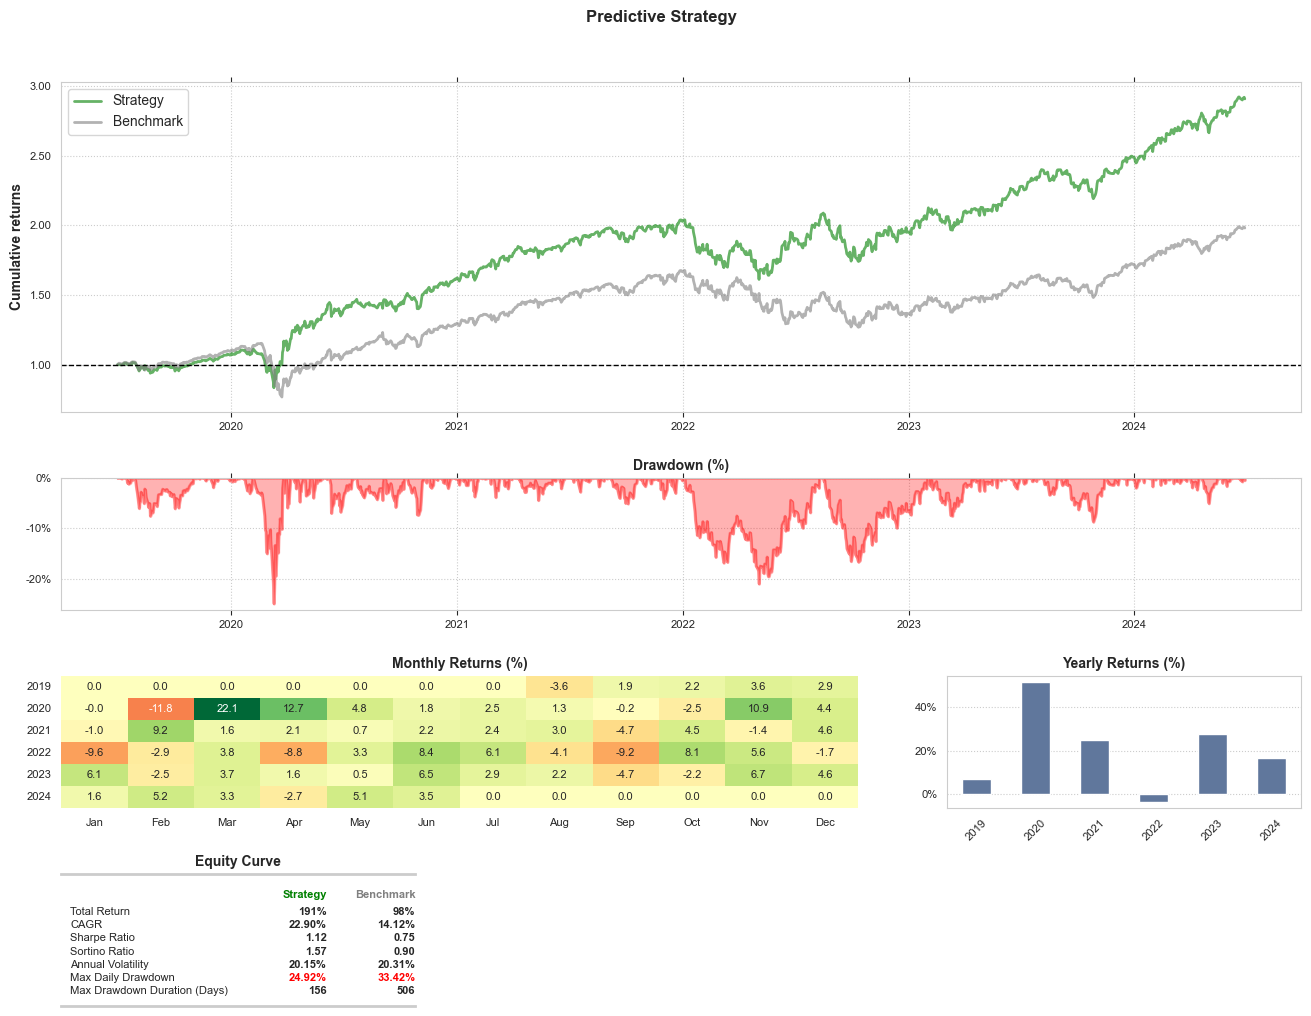

Backtest completed. Check the generated tearsheet for results.


In [7]:
csv_file = './data/unprocessed/SPY.csv'
initial_cash = 1_000_000  # $1,000,000 initial capital
lookback_period = 5  # Number of previous trading days to use for prediction

results, tearsheet = run_backtest(csv_file, initial_cash, lookback_period)
print("Backtest completed. Check the generated tearsheet for results.")

In [8]:
print(results)

None


In [9]:
strategy_returns = tearsheet.strategy_equity
benchmark_returns = tearsheet.benchmark_equity

In [10]:
strategy_statistics = tearsheet.get_results(strategy_returns)
benchmark_statistics = tearsheet.get_results(benchmark_returns)

<Axes: title={'center': 'Benchmark Equity Growth'}>

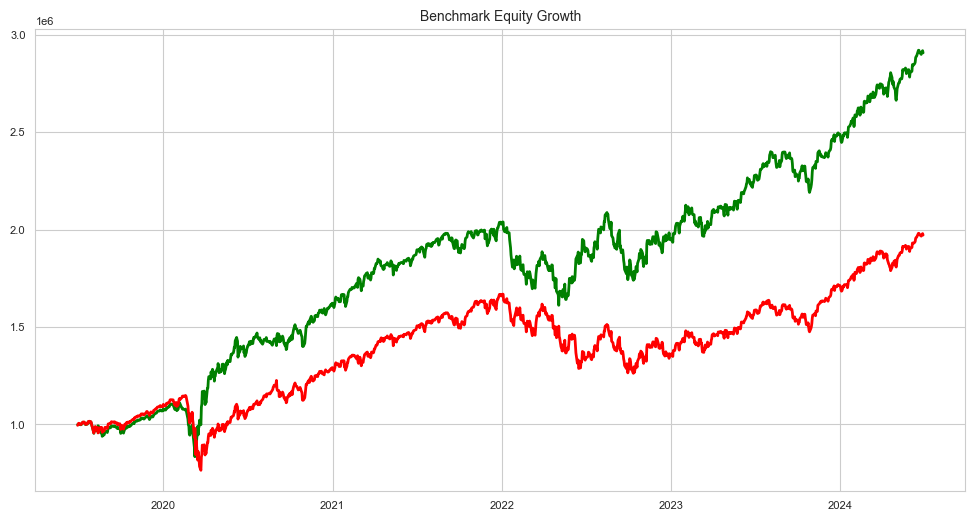

In [11]:
growth = strategy_statistics['equity'] - benchmark_statistics['equity']

strategy_statistics['equity'].plot(title='Strategy Equity Growth', figsize=(12, 6), color='green', lw=2)
benchmark_statistics['equity'].plot(title='Benchmark Equity Growth', figsize=(12, 6), color='red', lw=2)

<Axes: title={'center': 'Strategy Growth Over Benchmark'}>

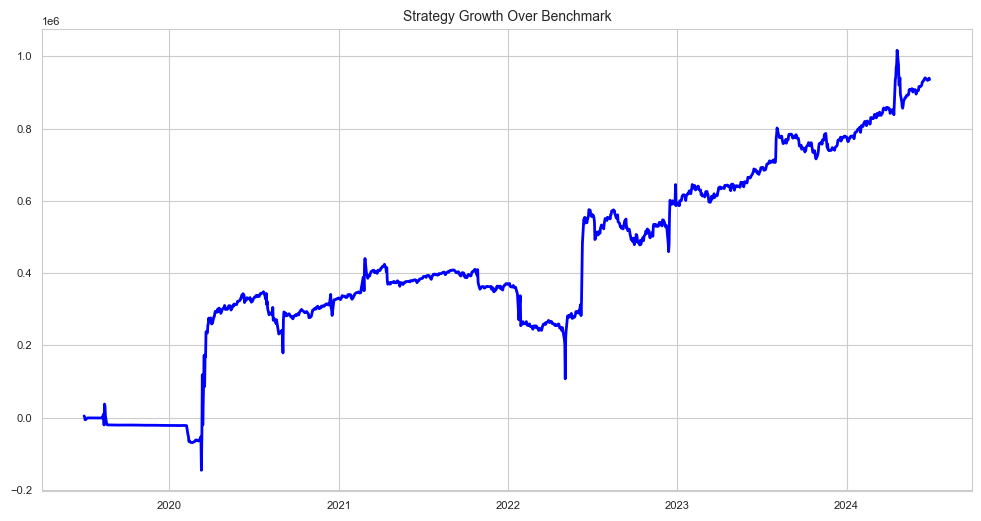

In [12]:
# Plot the growth of the strategy over the benchmark
growth.plot(title='Strategy Growth Over Benchmark', figsize=(12, 6), color='blue', lw=2)

In [39]:
import matplotlib.pyplot as plt
import qstrader.statistics.performance as perf
import seaborn as sns
from matplotlib import cm


def monthly_returns(stats, ax=None, **kwargs):
        """
        Plots a heatmap of the monthly returns.
        """
        returns = stats['returns']
        if ax is None:
            ax = plt.gca()

        monthly_ret = perf.aggregate_returns(returns, 'monthly')
        monthly_ret = monthly_ret.unstack()
        monthly_ret = np.round(monthly_ret, 3)
        monthly_ret.rename(
            columns={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                     5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                     9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'},
            inplace=True
        )

        sns.heatmap(
            monthly_ret.fillna(0) * 100.0,
            annot=True,
            fmt="0.1f",
            annot_kws={"size": 8},
            alpha=1.0,
            center=0.0,
            cbar=False,
            cmap=cm.RdYlGn,
            ax=ax, **kwargs)
        ax.set_title('Monthly Returns (%)', fontweight='bold')
        ax.set_ylabel('')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xlabel('')

        return monthly_ret

def weekly_returns(stats, ax=None, **kwargs):
        """
        Plots a heatmap of the monthly returns.
        """
        returns = stats['returns']
        if ax is None:
            ax = plt.gca()

        monthly_ret = perf.aggregate_returns(returns, 'weekly')
        monthly_ret = monthly_ret.unstack()
        monthly_ret = np.round(monthly_ret, 3)

        sns.heatmap(
            monthly_ret.fillna(0) * 100.0,
            annot=True,
            fmt="0.1f",
            annot_kws={"size": 8},
            alpha=1.0,
            center=0.0,
            cbar=False,
            cmap=cm.RdYlGn,
            ax=ax, **kwargs)
        ax.set_title('Monthly Returns (%)', fontweight='bold')
        ax.set_ylabel('')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xlabel('')

        return monthly_ret

In [65]:
def distribution(df):
    df = df.copy()
    df = df * 100.0
    # Flatten the DataFrame to a 1D array
    data = df.values.flatten()

    # Drop any NaN values (if present)
    data = data[~np.isnan(data)]

    # Calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data)

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True, color='skyblue', stat='density', linewidth=0)

    # Add lines for mean and standard deviation
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=2, label=f'+1 Std Dev: {mean + std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=2, label=f'-1 Std Dev: {mean - std:.2f}')

    # Add titles and labels
    plt.title('Distribution of Returns')
    plt.xlabel('Return (%)')
    plt.ylabel('Density')
    plt.legend()

    plt.show()

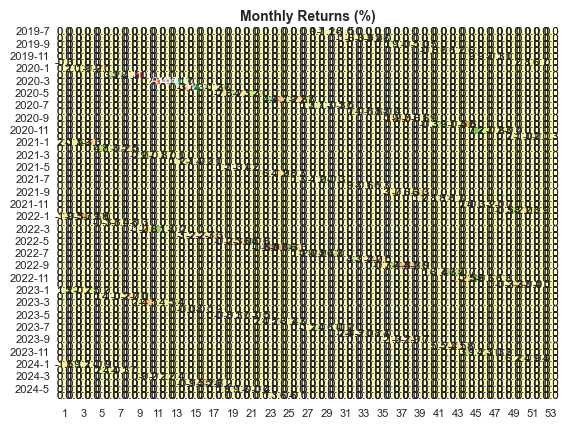

In [66]:
strategy_weekly_returns = weekly_returns(strategy_statistics)
benchmark_weekly_returns = weekly_returns(benchmark_statistics)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,NaN,NaN,NaN,NaN,NaN,NaN,0.000,-0.036,0.019,0.022,0.036,0.029
2020,-0.000,-0.118,0.221,0.127,0.048,0.018,0.025,0.013,-0.002,-0.025,0.109,0.044
2021,-0.010,0.092,0.016,0.021,0.007,0.022,0.024,0.030,-0.047,0.045,-0.014,0.046
2022,-0.096,-0.029,0.038,-0.088,0.033,0.084,0.061,-0.041,-0.092,0.081,0.056,-0.017
2023,0.061,-0.025,0.037,0.016,0.005,0.065,0.029,0.022,-0.047,-0.022,0.067,0.046
2024,0.016,0.052,0.033,-0.027,0.051,0.035,NaN,NaN,NaN,NaN,NaN,NaN


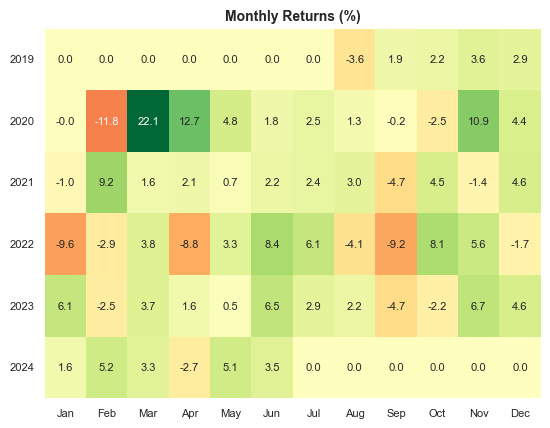

In [67]:
strategy_monthly_return = monthly_returns(strategy_statistics)
strategy_monthly_return

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,NaN,NaN,NaN,NaN,NaN,NaN,0.006,-0.017,0.019,0.022,0.036,0.029
2020,-0.000,-0.078,-0.124,0.126,0.047,0.018,0.058,0.069,-0.037,-0.025,0.108,0.037
2021,-0.010,0.028,0.045,0.053,0.007,0.022,0.024,0.030,-0.046,0.070,-0.008,0.046
2022,-0.052,-0.029,0.037,-0.087,0.002,-0.082,0.091,-0.041,-0.092,0.081,0.055,-0.057
2023,0.062,-0.025,0.037,0.016,0.005,0.064,0.033,-0.016,-0.047,-0.022,0.091,0.045
2024,0.016,0.052,0.033,-0.040,0.050,0.035,NaN,NaN,NaN,NaN,NaN,NaN


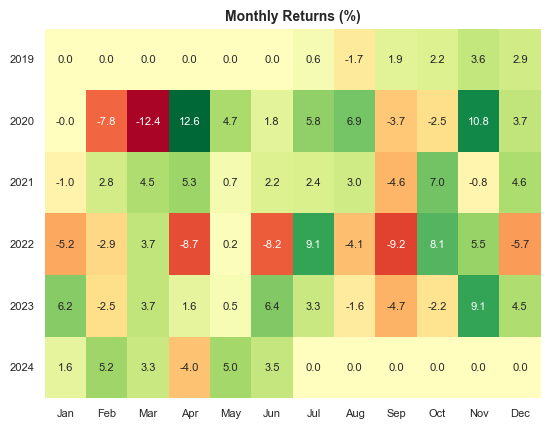

In [68]:
benchmark_monthly_returns = monthly_returns(benchmark_statistics)
benchmark_monthly_returns

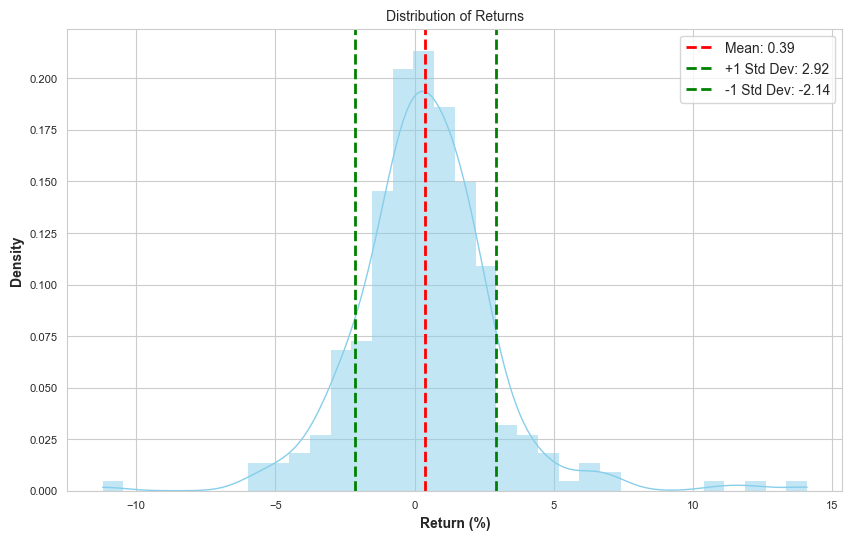

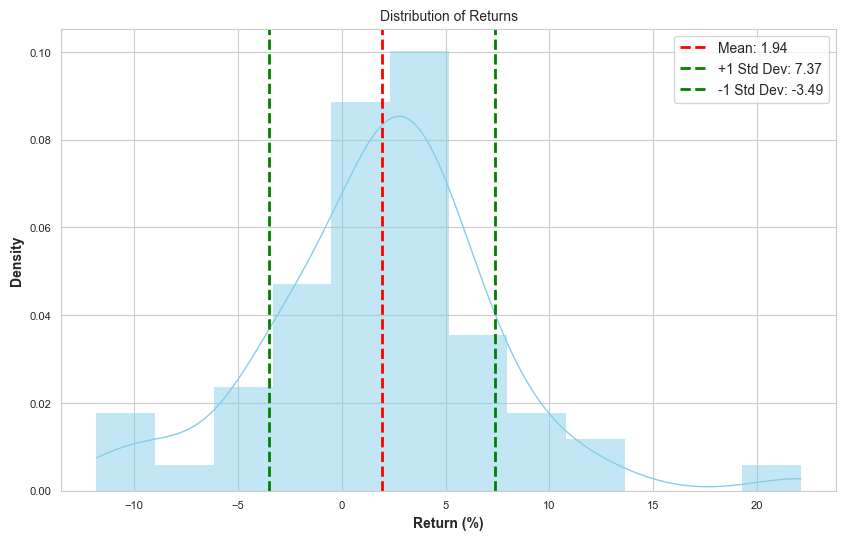

In [69]:
distribution(strategy_weekly_returns)
distribution(strategy_monthly_return)